In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from glob import glob 
# from sklearn.cluster import KMeans
from collections import Counter
# from skimage.color import rgb2lab, deltaE_cie76
import pandas as pd



In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

# def show_anns(anns):
#     if len(anns) == 0:
#         return
#     sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
#     ax = plt.gca()
#     ax.set_autoscale_on(False)

#     img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
#     img[:,:,3] = 0
#     for ann in sorted_anns:
#         m = ann['segmentation']
#         color_mask = np.concatenate([np.random.random(3), [0.35]])
#         img[m] = color_mask
#     ax.imshow(img)


color_mappings = {0: [224, 0, 0], 1: [138, 43, 226]}

for k in color_mappings:
    for i in range(3):
        color_mappings[k][i] /= 255.0

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns[:128]:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = color_mappings[1]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
def preprocess_histograms(image):
    #seperating colour channels
    B = image[:,:,0] #blue layer
    G = image[:,:,1] #green layer
    R = image[:,:,2] #red layer
    # equalize the histograms 
    b_equi = cv2.equalizeHist(B)
    g_equi = cv2.equalizeHist(G)
    r_equi = cv2.equalizeHist(R)
    equi_im = cv2.merge([b_equi,g_equi,r_equi])
    return equi_im

def get_image(image_path):
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = preprocess_histograms( image=image)
    
    return image

In [4]:
def show_images_grid(images, titles=None, figsize=(20, 20)):
    """Displays a grid of images with optional titles."""

    num_images = len(images)
    rows = int(num_images /5 )
    cols = 5

    # Create a figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Flatten the subplots array for easier iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i]
            ax.imshow(img)
            # ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
            ax.axis('off')  # Hide axes

            if titles:
                ax.set_title(titles[i])
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()
    
def background_to_black ( image, index ):
    # Apply the mask to the image
    masked_img = image.copy()
    masked_pixels = masked_img[masks[index]['segmentation']==True]
    masked_img[masks[index]['segmentation']==False] = (0, 0, 0)  # Set masked pixels to black
    return masked_img ,masked_pixels

def get_sorted_by_area(image, anns):
    area_list=[]
    cropped_image_dic ={}
    mask_number = [] 
    mask_pixles_dic = {}
    for i in range(len(anns)):
        x, y, width, height = anns[i]['bbox']
        area = anns[i]["area"]
        image_b, masked_pixels = background_to_black(image=image, index=i)
        cropped_image = image_b[int(y):int(y+height), int(x):int(x+width)]

        area_list.append(area)
        cropped_image_dic[i] = cropped_image
        mask_pixles_dic[i] = masked_pixels
        mask_number.append(i)
    df = pd.DataFrame([area_list,mask_number])
    df = df.T
    df.columns = ['area','mask_number']
    df.sort_values(by='mask_number', ascending=True, inplace=True)
    df.dropna(inplace=True)
    return df , cropped_image_dic , mask_pixles_dic

In [5]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_colors(image, number_of_colors, show_chart):
    
    # modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    # modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    modified_image = image.reshape( image.shape[0]*image.shape[1],3  )
    
    clf = KMeans(n_clusters = number_of_colors, n_init='auto', random_state=73)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_

    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]


    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = rgb_colors, colors = hex_colors)
    
    return rgb_colors

In [6]:
def drop_black_from_top_colors(top_colors_list):
    min_values = []
    for i in range(len(top_colors_list)):
        curr_color = rgb2lab(np.uint8(np.asarray([[top_colors_list[i]]])))
        diff = deltaE_cie76((0, 0, 0), curr_color)
        # print (diff, type(diff))
        min_values.append(diff[0][0])
        lowest_value_index = np.argmin(min_values) 
    top_colors_list.pop(lowest_value_index)
    return top_colors_list


def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    # discard black
    image_colors = drop_black_from_top_colors(image_colors)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    diff_list =[]
    for i in range(len(image_colors)):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        # print(diff[0][0])
        diff_list.append(diff[0][0])
    diff_avg = np.mean(diff_list)
    if diff_avg < threshold:
        return diff_avg
    else:
        # a euclidian difference of 1000 should be noticible 
        return 1000
    

def calculate_distances_to_colors(image):
    # color chart but in RGB 
    color_map_RGB = {
    'B1': (247, 248, 232),
    'B2': (243, 244, 192),
    'B3': (234, 235, 137),
    'B4': (200, 206, 57),
    'B5': (148, 157, 56),
    'B6': (92, 116, 52),
    'C1': (247, 235, 232),
    'C2': (246, 201, 192),
    'C3': (240, 156, 136),
    'C4': (207, 90, 58),
    'C5': (155, 50, 32),
    'C6': (101, 27, 13),
    'D1': (246, 235, 224),
    'D2': (246, 219, 191),
    'D3': (239, 188, 135),
    'D4': (211, 147, 78),
    'D5': (151, 89, 36),
    'D6': (106, 58, 22),
    'E1': (247, 242, 227),
    'E2': (246, 232, 191),
    'E3': (240, 213, 136),
    'E4': (209, 174, 68),
    'E5': (155, 124, 45),
    'E6': (111, 85, 34)
    }
    
    # get the distance 
    final_distances = {}
    for key in color_map_RGB.keys():
        max_val = match_image_by_color( image=image, color=color_map_RGB[key], number_of_colors=6)
        if max_val != 0 :
            final_distances[key]=max_val
    df_final = pd.DataFrame.from_dict(final_distances,orient='index',columns=["Distance"])
    df_final.sort_values(by="Distance",ascending=True,inplace=True)
    color_keys_selected= df_final.head(n=3).index.to_list()
    color_selected_distance = df_final["Distance"].head(n=3).to_list()
    lower_y_limit = color_selected_distance[0] - 0.5
    higher_y_limit = color_selected_distance[-1] + 0.5
    hex_colors_map = [RGB2HEX(color_map_RGB[key]) for key in color_keys_selected]
    return color_keys_selected, color_selected_distance, lower_y_limit, higher_y_limit,hex_colors_map

def plot_compare(img1_rgb,color_keys_selected, color_selected_distance, lower_y_limit, higher_y_limit,hex_colors_map):
    # Create a figure and subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20, 10))  # Adjust figsize as needed

    # Display the images
    ax1.imshow(img1_rgb)
    ax1.set_title("Image 1")
    ax1.axis('off') 

    ax2.bar(color_keys_selected,color_selected_distance ,color = hex_colors_map)
    ax2.set_title("Image 2")

    ax2.set_ylabel("Euclidian distance from \n top 5 colors detected")
    ax2.set_xlabel("Color code in chart")
    
    plt.xlabel("Color code in chart")
    plt.ylim(lower_y_limit,higher_y_limit)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def process_images(image, masks):
    image_dataframe, cropped_image_list , mask_pixels_dict = get_sorted_by_area( image=image , anns=masks )
    top_six_img_by_area = image_dataframe['mask_number'].head(n=25).to_list()
    list_of_images = [ cropped_image_list [idx ] for idx in top_six_img_by_area  ]
    # titles = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6','Image 7','Image 8','Image 9','Image 10']
    # titles = [ f"Image_{i}" for i in len(list_of_images)]
    titles = [str(x) for x in range(len(list_of_images)) ]
    return list_of_images , titles



    

In [7]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
# sam_checkpoint = "../models/sam_vit_l_0b3195.pth"  # this is 31% of the memory of a V100 
# sam_checkpoint = "../models/sam_vit_b_01ec64.pth" # this is even less 

model_type = "vit_b"


sam_checkpoint = {'vit_h':'../models/sam_vit_h_4b8939.pth', 
                  'vit_l':'../models/sam_vit_l_0b3195.pth',
                #   'vit_b':'../models/sam_vit_b_01ec64.pth',
                  'vit_b': 'checkpoints/vit_b_coralscop.pth'}
                  

# device = "cuda"

# The following line is for the use of my second gpu wich is free
device = torch.device("cuda:0")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint[model_type])
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
points_per_side = 32
pred_iou_thresh = 0.72
stability_score_thresh = 0.62
    # mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Requires open-cv to run post-processing
    )

loading from checkpoints/vit_b_coralscop.pth


/home/barradd/Documents/GitHub/CoralSCOP/segment_anything/build_sam.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [8]:
# path to the images 
# /home/barradd/Documents/GitHub/CoralSCOP/vis_img_output/TL8_2799.JPG
# /home/barradd/Documents/GitHub/CoralSCOP/other/Exp8-CBS-080724/TL8_2799.jpg
main_path = '/home/barradd/Documents/GitHub/CoralSCOP/other/Exp8-CBS-080724'
path_to_coral = f'{main_path}/TL8_2799.jpg'
# path_to_coral = f'{main_path}/AUSTRALES_AUS_RAI1###20M###20190504_UTP_QUADRAT_AUSRAI1_20M_5.jpg'
# path_to_coral = f'{main_path}/B1_P1_AC_09-17.JPG'

In [9]:
image = get_image(path_to_coral)
# image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
# image = cv2.resize(image, (1200, 800), interpolation = cv2.INTER_AREA)
# image = cv2.resize(image, (1800, 1200), interpolation = cv2.INTER_AREA)


In [10]:
masks = mask_generator.generate(image)

In [11]:
type(masks)

list

In [12]:
len(masks)

27

In [13]:
type(image)

numpy.ndarray

In [14]:
# for m in range(len(masks)):
#     x, y, width, height = masks[m]['bbox']
#     cropped_image = image[int(y):int(height),int(x):int(width)]
#     print(len(cropped_image))
#     if len(cropped_image) != 0 :
#         filename = f'savedImage_{m}.jpg'
#         cv2.imwrite( filename,cropped_image)

#     # print()

In [15]:
masks[0]['segmentation'].shape

(5504, 8256)

In [16]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'cate_preds', 'fc_features', 'similarity', 'point_coords', 'stability_score', 'crop_box'])

In [17]:
masks[0]['bbox']

[523.0, 2459.0, 669.0, 641.0]

In [18]:
masks[0]['segmentation']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [19]:
def experiment_grid(model_type, image):
    mask_generator = load_sam_model(model_type=model_type)
    masks = mask_generator.generate(image=image)
    list_of_images = process_images(image = image, masks= masks)
    titles = [str(x) for x in range(len(list_of_images)) ]
    show_images_grid( images=list_of_images , titles=titles )

In [20]:

def is_cuda_available():
    """Checks if CUDA is available and can be used by PyTorch.

    Returns:
        bool: True if CUDA is available, False otherwise.
    """

    return torch.cuda.is_available()

def load_sam_model(model_type):
    ## Load the model for segmentation ( the SAM deep learning algorithm )
    # from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
    # path_to_models = "/".join(os.getcwd().split("/")[:-1])

    # model_type = "vit_l"

    sam_checkpoint = {'vit_h':'../models/sam_vit_h_4b8939.pth', 
                  'vit_l':'../models/sam_vit_l_0b3195.pth',
                #   'vit_b':'../models/sam_vit_b_01ec64.pth',
                  'vit_b': 'checkpoints/vit_b_coralscop.pth'}

    if is_cuda_available():
        # The following line is for using my second GPU, free
        # device = torch.device("cuda:1")
        print("CUDA is available!")
        device = torch.device("cuda:1")
    else:
        print("CUDA is not available. Using CPU.")
        device = torch.device("cpu")


    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint[model_type])
    sam.to(device=device)
# python test.py --model_type vit_b --checkpoint_path ./checkpoints/vit_b_coralscop.pth --iou_threshold 0.72 --sta_threshold 0.62 --test_img_path ./demo_imgs/ --output_path ./demo_imgs_output --gpu 0 --point_number 32
    points_per_side = 32
    pred_iou_thresh = 0.72
    stability_score_thresh = 0.62
    # mask_generator = SamAutomaticMaskGenerator(sam)
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Requires open-cv to run post-processing
    )
    return mask_generator

In [21]:


list_of_images , titles = process_images(image = image, masks= masks)


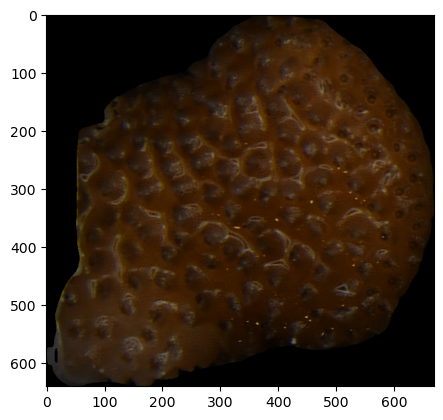

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(list_of_images[0])
plt.axis('on')
plt.show() 

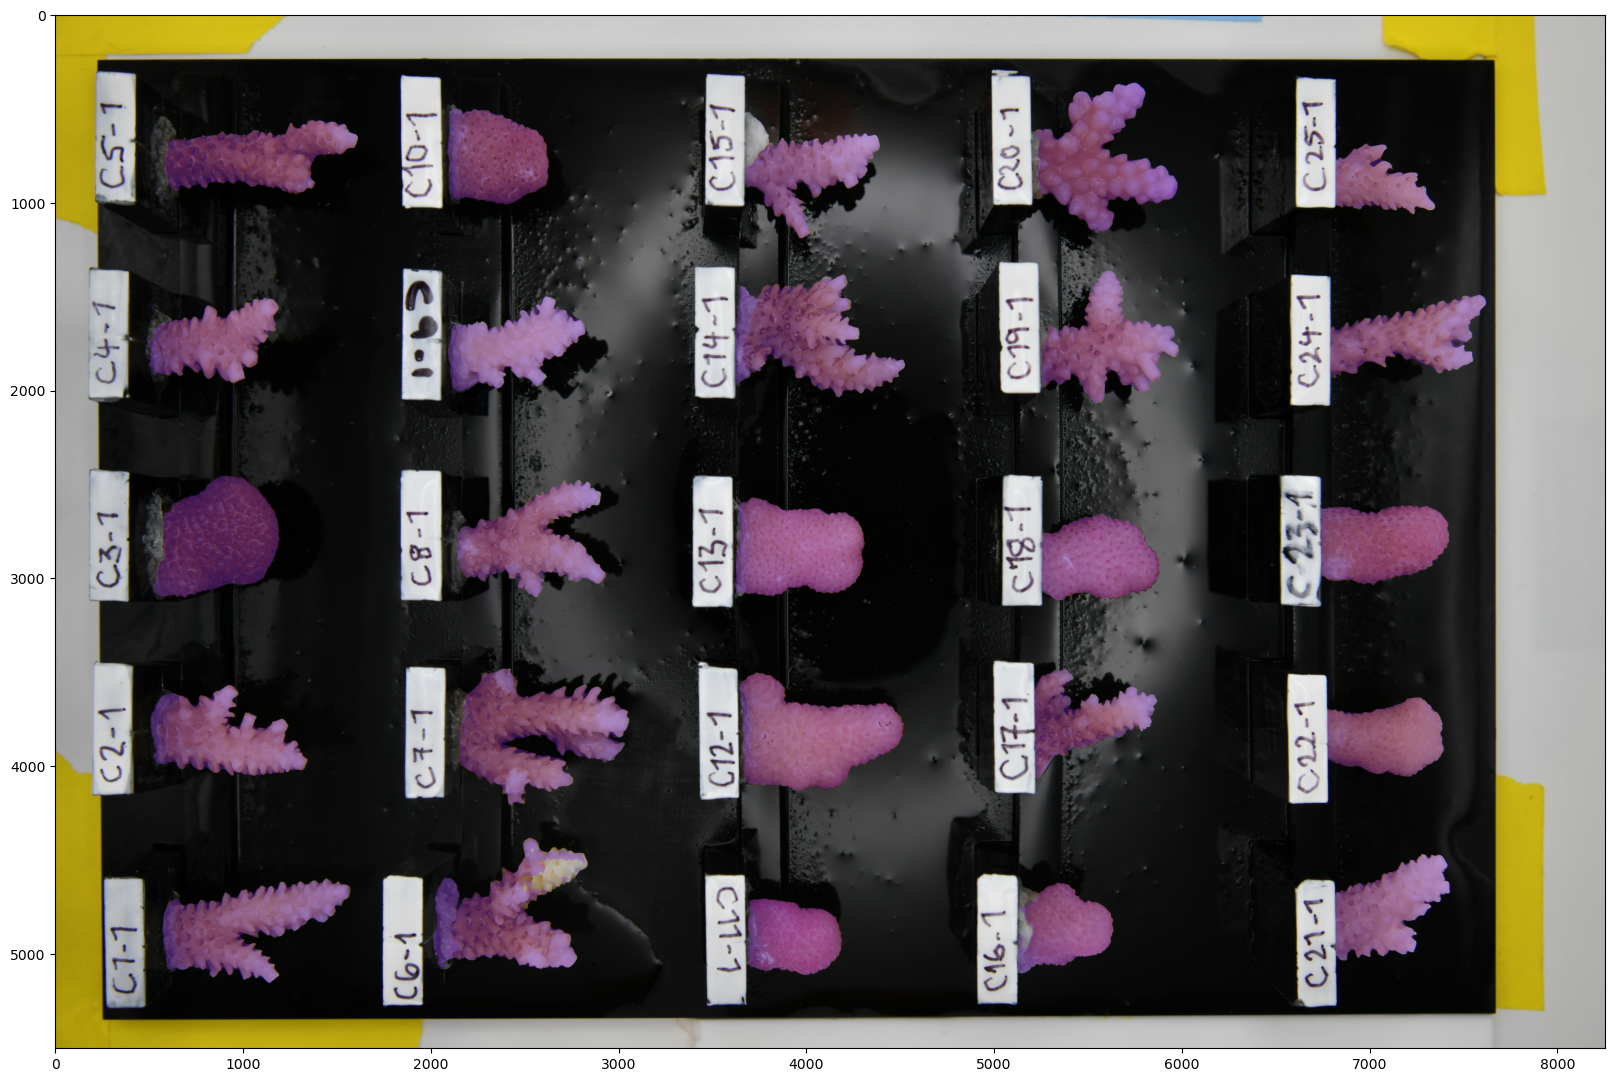

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)

plt.axis('on')
plt.show() 

In [24]:
## this works and save the images with the correct color
# for image_segment,t in zip(list_of_images,titles):
#     image_segment = cv2.cvtColor(image_segment, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(f'other/image_segment_{t}.jpg',image_segment)

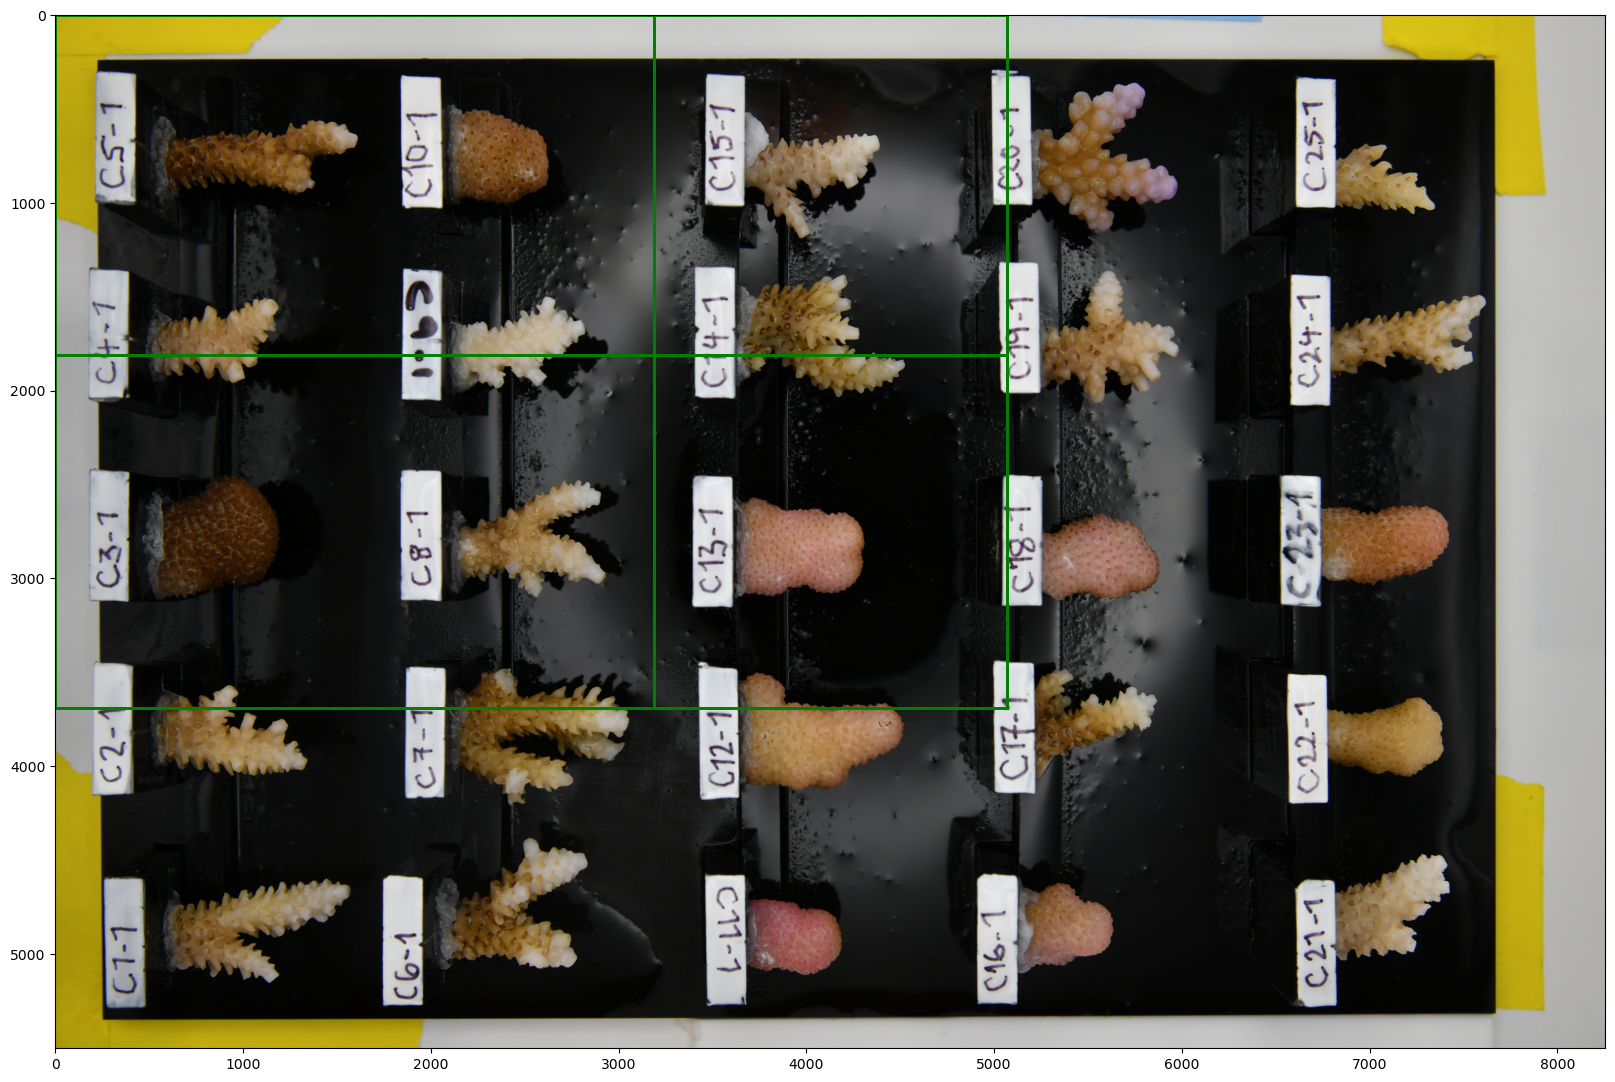

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
# input_box = np.array([5130., 4626.,  503.,  474.])
# show_box(input_box, plt.gca())

# for ann in masks[0]['bbox']:
for i in range(len(masks)):
    # x, y, width, height = masks['bbox']
    # input_box = np.array([x,height, y,width])
    show_box(masks[i]['crop_box'], plt.gca())
# show_mask(masks[0], plt.gca())
# show_box(input_box, plt.gca())
# show_box(input_box_2, plt.gca() )
# show_box(input_box_3, plt.gca() )
# show_box(input_box_4, plt.gca() )
# show_box(input_box_5, plt.gca() )


plt.axis('on')
plt.show()

In [26]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'cate_preds', 'fc_features', 'similarity', 'point_coords', 'stability_score', 'crop_box'])

In [44]:
type(masks[0]['point_coords'][0][1])

float

In [49]:
for i in range(len(masks)):
    print (masks[i]['area'],masks[i]['predicted_iou'],masks[i]['stability_score'], masks[i]['point_coords'][0])

312527 0.9630011916160583 0.9694547057151794 [1108.40625, 2883.59375]
252430 0.9583549499511719 0.9653419852256775 [791.71875, 807.40625]
211011 0.9448183178901672 0.9588543772697449 [2691.84375, 1730.15625]
288236 0.9370933175086975 0.9479246139526367 [4275.28125, 2883.59375]
262578 0.9363654851913452 0.9547089338302612 [2691.84375, 2883.59375]
221042 0.9358419179916382 0.9727387428283691 [2375.15625, 807.40625]
302699 0.9135547280311584 0.9587998390197754 [3958.59375, 1499.46875]
196331 0.9083457589149475 0.9399686455726624 [791.71875, 1730.15625]
190754 0.8995654582977295 0.9472501873970032 [3958.59375, 807.40625]
30430 0.7525184750556946 0.9002813100814819 [3641.90625, 1730.15625]
352739 0.9377622008323669 0.9670476913452148 [3958.59375, 3773.84375]
164298 0.9322457909584045 0.9654749035835266 [3958.59375, 4927.28125]
251680 0.9314063191413879 0.9516027569770813 [791.71875, 4004.53125]
298087 0.9009349942207336 0.9411407709121704 [791.71875, 4927.28125]
45198 0.8357663154602051 0.8

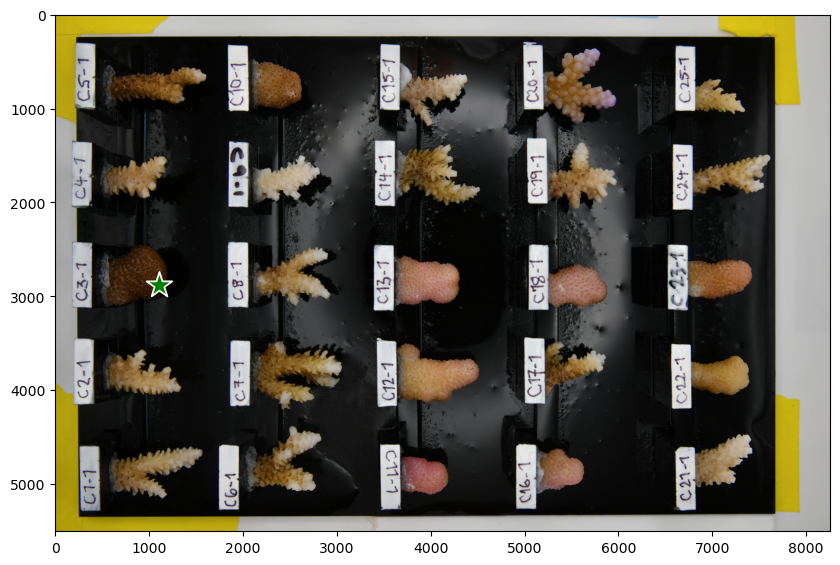

In [51]:
input_point = np.array([[1108.40625, 2883.59375]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

[[1108.40625 2883.59375]] [1]
[[791.71875 807.40625]] [1]
[[2691.84375 1730.15625]] [1]
[[4275.28125 2883.59375]] [1]
[[2691.84375 2883.59375]] [1]
[[2375.15625  807.40625]] [1]
[[3958.59375 1499.46875]] [1]
[[ 791.71875 1730.15625]] [1]
[[3958.59375  807.40625]] [1]
[[3641.90625 1730.15625]] [1]
[[3958.59375 3773.84375]] [1]
[[3958.59375 4927.28125]] [1]
[[ 791.71875 4004.53125]] [1]
[[ 791.71875 4927.28125]] [1]
[[2058.46875 4696.59375]] [1]
[[2691.84375 4927.28125]] [1]
[[5564.15625 2883.59375]] [1]
[[6830.90625 2652.90625]] [1]
[[5880.84375 1730.15625]] [1]
[[6830.90625  807.40625]] [1]
[[7147.59375 1730.15625]] [1]
[[5564.15625 1038.09375]] [1]
[[7147.59375 4004.53125]] [1]
[[6830.90625 4696.59375]] [1]
[[5247.46875 3773.84375]] [1]
[[2375.15625 3773.84375]] [1]
[[5247.46875 4696.59375]] [1]


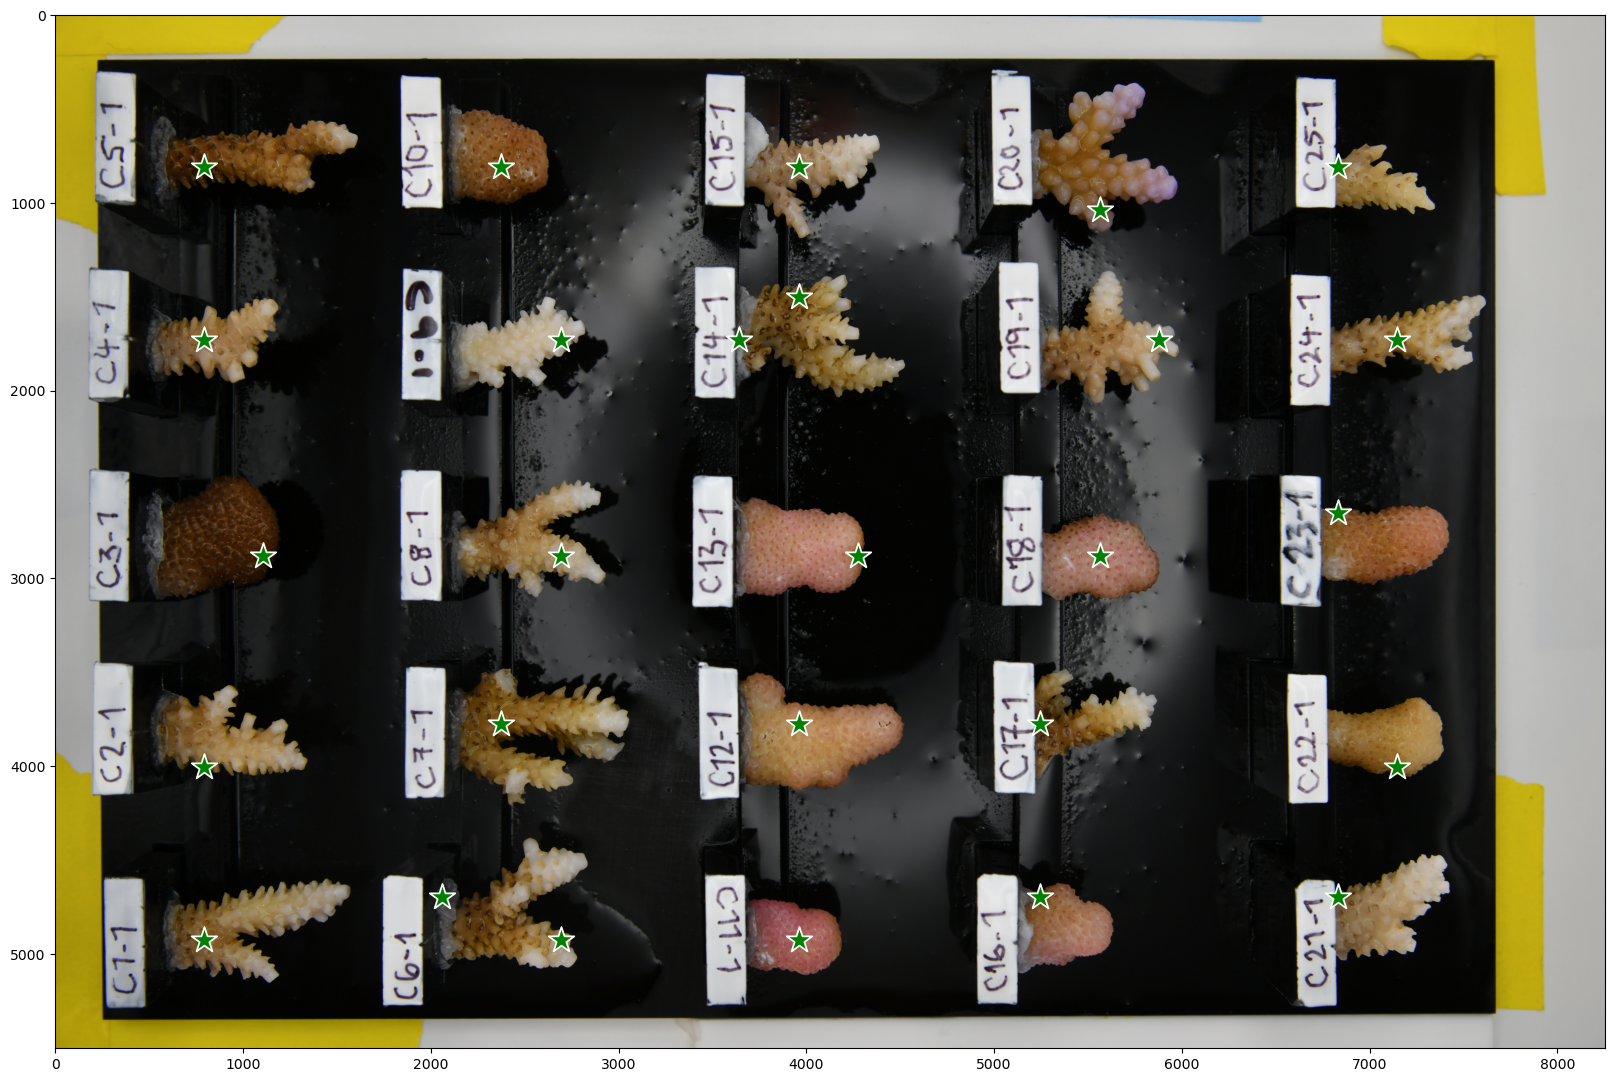

In [55]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
# input_box = np.array([5130., 4626.,  503.,  474.])
# show_box(input_box, plt.gca())

# for ann in masks[0]['bbox']:
for i in range(len(masks)):
    # x, y, width, height = masks['bbox']
    # input_box = np.array([x,height, y,width])
    # show_box(masks[i]['crop_box'], plt.gca())
    input_point = np.array(masks[i]['point_coords'])
    input_label = np.array([1])
    print (input_point,input_label)
    show_points(input_point, input_label, plt.gca())

# show_mask(masks[0], plt.gca())
# show_box(input_box, plt.gca())
# show_box(input_box_2, plt.gca() )
# show_box(input_box_3, plt.gca() )
# show_box(input_box_4, plt.gca() )
# show_box(input_box_5, plt.gca() )


plt.axis('on')
plt.show()

In [58]:
def get_sorted_by_coordinates(image, anns):
    area_list=[]
    cropped_image_dic ={}
    mask_number = [] 
    mask_pixles_dic = {}
    X_coord_list , Y_coord_list = [] , [] 
    for i in range(len(anns)):
        x, y, width, height = anns[i]['bbox']
        area = anns[i]["area"]
        image_b, masked_pixels = background_to_black(image=image, index=i)
        cropped_image = image_b[int(y):int(y+height), int(x):int(x+width)]
        x_coord, y_coord = anns[i]['point_coords'][0]
        X_coord_list.append(x_coord) 
        Y_coord_list.append(y_coord)


        area_list.append(area)
        cropped_image_dic[i] = cropped_image
        mask_pixles_dic[i] = masked_pixels
        mask_number.append(i)
    df = pd.DataFrame([area_list,mask_number,X_coord_list,Y_coord_list])
    df = df.T
    df.columns = ['area','mask_number','X_corrd','Y_coord']
    df.sort_values(by=['X_corrd','Y_coord'], ascending=True, inplace=True)
    df.dropna(inplace=True)
    return df , cropped_image_dic , mask_pixles_dic

In [71]:
def process_images_and_sort_by_coordinates(image, masks):
    image_dataframe, cropped_image_list , mask_pixels_dict = get_sorted_by_coordinates( image=image , anns=masks )
    top_six_img_by_area = image_dataframe['mask_number'].head(n=25).to_list()
    list_of_images = [ cropped_image_list [idx ] for idx in top_six_img_by_area  ]
    print (image_dataframe.columns)
    titles = [  ] 
    for idx , x_coord  in zip(image_dataframe.index.to_list(), image_dataframe['X_corrd'].to_list() ) :
        titles.append(f"image_index_{idx}_mask_id_{x_coord}")
    # titles = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6','Image 7','Image 8','Image 9','Image 10']
    # titles = [ f"Image_{i}" for i in len(list_of_images)]
    # titles = [str(x) for x in range(len(list_of_images)) ]
    return list_of_images , titles

In [72]:
list_of_images , titles = process_images_and_sort_by_coordinates(image = image, masks= masks)

Index(['area', 'mask_number', 'X_corrd', 'Y_coord'], dtype='object')


In [73]:
titles

['image_index_1_mask_id_791.71875',
 'image_index_7_mask_id_791.71875',
 'image_index_12_mask_id_791.71875',
 'image_index_13_mask_id_791.71875',
 'image_index_0_mask_id_1108.40625',
 'image_index_14_mask_id_2058.46875',
 'image_index_5_mask_id_2375.15625',
 'image_index_25_mask_id_2375.15625',
 'image_index_2_mask_id_2691.84375',
 'image_index_4_mask_id_2691.84375',
 'image_index_15_mask_id_2691.84375',
 'image_index_9_mask_id_3641.90625',
 'image_index_8_mask_id_3958.59375',
 'image_index_6_mask_id_3958.59375',
 'image_index_10_mask_id_3958.59375',
 'image_index_11_mask_id_3958.59375',
 'image_index_3_mask_id_4275.28125',
 'image_index_24_mask_id_5247.46875',
 'image_index_26_mask_id_5247.46875',
 'image_index_21_mask_id_5564.15625',
 'image_index_16_mask_id_5564.15625',
 'image_index_18_mask_id_5880.84375',
 'image_index_19_mask_id_6830.90625',
 'image_index_17_mask_id_6830.90625',
 'image_index_23_mask_id_6830.90625',
 'image_index_20_mask_id_7147.59375',
 'image_index_22_mask_id_7